In [1]:
import numpy as np
from qutip import Options
import qutip as qt
import matplotlib.pyplot as plt
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode

opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()  # None

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interactive, Output

# Initial qubit frequencies and SNAIL frequency
freqs = np.array([4, 6, 4.665925])  # q1, q2, q3 frequencies
snail_freq = 5.6675931  # SNAIL frequency


# Adjust qubit frequencies based on a shrink factor
def adjust_frequencies(freqs, snail_freq, shrink_factor):
    # Combine the frequencies and the SNAIL frequency into one array
    all_freqs = np.append(freqs, snail_freq)

    # Calculate the midpoint of all frequencies including the SNAIL frequency
    midpoint = np.mean(all_freqs)

    # Translate all frequencies to the origin (midpoint becomes the new origin)
    translated_freqs = all_freqs - midpoint

    # Apply the shrink factor (scaling about the new origin)
    scaled_freqs = translated_freqs * shrink_factor

    # Translate all frequencies back to the original location
    adjusted_freqs = scaled_freqs + midpoint

    # Separate the qubit frequencies from the SNAIL frequency
    adjusted_qubit_freqs = adjusted_freqs[:-1]
    adjusted_snail_freq = adjusted_freqs[-1]

    return adjusted_qubit_freqs, adjusted_snail_freq

In [3]:
# Initial qubit frequencies and SNAIL frequency
freqs = np.array([4, 6, 4.665925])  # q1, q2, q3 frequencies
snail_freq = 5.6675931  # SNAIL frequency

adjusted_freqs, adjusted_snail = adjust_frequencies(
    freqs, snail_freq, shrink_factor=1.0
)
adjusted_freqs, adjusted_snail

(array([4.      , 6.      , 4.665925]), 5.6675931)

In [4]:
qubit1 = QubitMode(
    name="q1", dim=2, freq=adjusted_freqs[0], alpha=-0.161, T1=1e2, T2=5e1
)
qubit2 = QubitMode(
    name="q2", dim=2, freq=adjusted_freqs[1], alpha=-0.1275, T1=1e2, T2=5e1
)
qubit3 = QubitMode(
    name="q3", dim=2, freq=adjusted_freqs[2], alpha=-0.160, T1=1e2, T2=5e1
)
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(name="s", freq=adjusted_snail, g3=0.3, dim=10, T1=1e3, T2=5e2)

# define couplings so hybridizations are all equal
g2_0 = 2 * np.pi * 0.04
g2_1 = (
    g2_0
    * np.abs(adjusted_snail - adjusted_freqs[1])
    / np.abs(adjusted_snail - adjusted_freqs[0])
)
g2_2 = (
    g2_0
    * np.abs(adjusted_snail - adjusted_freqs[2])
    / np.abs(adjusted_snail - adjusted_freqs[0])
)
_couplings = {
    frozenset([qubit1, snail]): g2_0,
    frozenset([qubit2, snail]): g2_1,
    frozenset([qubit3, snail]): g2_2,
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

# get dressed frequencies
qubit_freqs = [qs.dressed_freqs.get(q) for q in qubits]

In [5]:
# Step 1. construct the linear Hamiltonian
HL = 0
# for m in qs.modes:
#     HL += m.freq * qs.modes_num[m]

HL += snail.freq * qs.modes_num[snail]

# Step 2. construct the non-linear part of the Hamiltonian
# add the SNAIL non-linearity
HNl = snail.g3 / 6 * (qs.modes_field[snail]) ** 3
for q in qubits:
    # HNl += q.alpha / 12 * (qs.modes_field[q]) ** 2
    HNl -= q.freq * (qs.modes_Z[q] / 2)

# Step 3. Add the coupling terms
Hc = 0
for c, g in qs.couplings.items():
    q1, q2 = c
    Hc += g * (qs.modes_field[q1] * qs.modes_field[q2])

H0 = HL + HNl + Hc

# pump_term = qs.modes_a_dag[snail] - qs.modes_a[snail]
pump_term = qs.modes_a_dag[snail] + qs.modes_a[snail]

In [6]:
# create an initial state
# psi0 = qs.prepare_tensor_fock_state([(qubit2, 1)])
eigenvalues, eigenvectors = H0.eigenstates()
psi0 = eigenvectors[3]  # [2] for 2 qubits+snail

In [7]:
# define desired unitary and expected final state
# assumes the iSWAP is on qubit1 and qubit2
# U = qt.tensor(
#     qt.qip.operations.iswap(N=2), qt.identity(qubit3.dim), qt.identity(snail.dim)
# )
U = qt.qip.operations.iswap(N=2)

psi0_rho = qt.ptrace(psi0, [0, 1])
expected_psi = qt.Qobj(U * psi0_rho * U.dag())

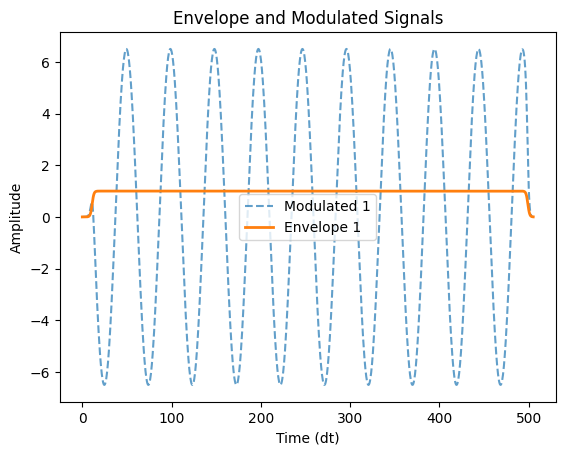

In [8]:
# Step 3. construct the pump term
# Define experiment constants
# define frequency and amplitude ranges
# drive at qubit-qubit conversion with some detuning
width_d = 500
N = 5

detuning_flist = 1000 * np.linspace(-0.005, 0.002, N)  # MHz
flist = 2 * np.pi / 1000 * (detuning_flist) + abs(qubit1.freq - qubit2.freq)
alist = np.linspace(4, 9, N)
args = {
    "shape": Pulse.smoothbox,
    "shape_params": {"t0": 5, "width": width_d},
}
t_list = np.linspace(0, 5 + width_d, 1000)

# plot an example pulse from the experiment to verify its shape
omega_p = flist[int(N / 2)]
amp_p = alist[int(N / 2)]
pulse = Pulse(omega=omega_p, amp=amp_p)

# Plot the Gaussian pulse shape
Pulse.plot_pulse([(pulse, args)], t_list)

H_pump = [pump_term, pulse.drive]

In [9]:
# # collapse operators
c_ops = []
# for mode in qs.modes:
# c_ops.append(mode.collapse_operators(qs))

In [10]:
def simulation_task(freq_amp_tuple):
    freq, amp = freq_amp_tuple
    pulse = Pulse(omega=freq, amp=amp)
    H_pump = [pump_term, pulse.drive]
    H = [H0, H_pump]

    solve_result = qt.mesolve(H, psi0, t_list, c_ops, args=args, options=opts)
    final_state = solve_result.states[-1]

    # ground_state_populations = [
    #     qs.mode_population_expectation(final_state, mode, 0) for mode in qs.modes
    # ]
    # Calculate fidelity with the expected final state
    final_state = qt.ptrace(final_state, [0, 1])
    fidelity = qt.fidelity(expected_psi, final_state)

    # Return input parameters along with the results
    return freq, amp, None, fidelity


# Prepare the parameters for parallel execution
freq_amp_pairs = [(f, a) for f in flist for a in alist]
# Run the simulations in parallel
results = qt.parallel.parallel_map(simulation_task, freq_amp_pairs, progress_bar=True)

12.0%. Run time:  16.95s. Est. time left: 00:00:02:04
20.0%. Run time:  17.37s. Est. time left: 00:00:01:09
32.0%. Run time:  17.86s. Est. time left: 00:00:00:37
40.0%. Run time:  18.82s. Est. time left: 00:00:00:28
52.0%. Run time:  32.88s. Est. time left: 00:00:00:30
60.0%. Run time:  33.54s. Est. time left: 00:00:00:22
72.0%. Run time:  34.41s. Est. time left: 00:00:00:13
80.0%. Run time:  34.94s. Est. time left: 00:00:00:08
92.0%. Run time:  36.39s. Est. time left: 00:00:00:03
100.0%. Run time:  41.77s. Est. time left: 00:00:00:00
Total run time:  41.78s


In [11]:
# Process results
# ground_state_populations = np.zeros((len(qs.modes), len(alist), len(flist)))
fidelity_matrix = np.zeros((len(alist), len(flist)))

freq_to_idx = {freq: idx for idx, freq in enumerate(flist)}
amp_to_idx = {amp: idx for idx, amp in enumerate(alist)}

# Process results with guaranteed matching of parameters and results
for result in results:
    freq, amp, populations, fidelity = result
    freq_idx = freq_to_idx[freq]
    amp_idx = amp_to_idx[amp]

    # # Store ground state populations
    # for k, pop in enumerate(populations):
    #     ground_state_populations[k, amp_idx, freq_idx] = pop

    # Store fidelity
    fidelity_matrix[amp_idx, freq_idx] = fidelity

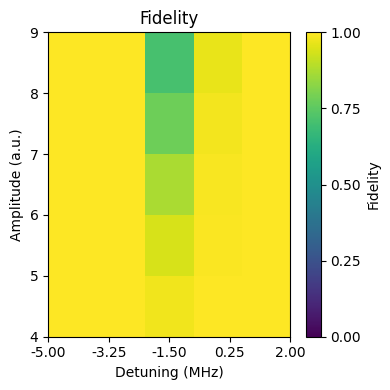

In [12]:
# Prepare the plot
# fig, axes = plt.subplots(1, len(qs.modes), figsize=(len(qs.modes) * 4, 4))

# Conversion factor from radian frequency to GHz
rad_to_GHz = 1 / (2 * np.pi)

# Define the number of ticks for the detuning x-axis
n_xticks = 5  # Adjust the number of ticks as needed

# plot fidelity instead
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
im = axes.imshow(
    fidelity_matrix,
    extent=[detuning_flist[0], detuning_flist[-1], alist[0], alist[-1]],
    aspect="auto",
    origin="lower",
    vmin=0.0,
    vmax=1.0,  # Set color bar scale from 0.0 to 1.0
)
axes.set_title("Fidelity")
axes.set_xlabel("Detuning (MHz)")
axes.set_ylabel("Amplitude (a.u.)")

# Customize x-axis ticks
xticks = np.linspace(detuning_flist[0], detuning_flist[-1], n_xticks)
axes.set_xticks(xticks)
axes.set_xticklabels([f"{x:.2f}" for x in xticks])  # Format the tick labels

# Add color bar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", label="Fidelity")
cbar.set_ticks(np.linspace(0, 1, 5))  # Customize color bar ticks


plt.tight_layout()
plt.show()

In [13]:
# Find the pulse parameters that maximize fidelity
max_fidelity = np.max(fidelity_matrix)
max_fidelity_indices = np.where(fidelity_matrix == max_fidelity)

# Since the indices are returned in a tuple of arrays, we take the first element
max_fidelity_amp_idx, max_fidelity_freq_idx = (
    max_fidelity_indices[0][0],
    max_fidelity_indices[1][0],
)

# Retrieve the amplitude and width that correspond to the maximum fidelity
max_fidelity_freq = flist[max_fidelity_freq_idx]
max_fidelity_amp = alist[max_fidelity_amp_idx]

print(f"Max fidelity: {max_fidelity:.4f}")
print(f"Pulse freq for max fidelity: {max_fidelity_freq:.2f} GHz")
print(f"Pulse amplitude for max fidelity: {max_fidelity_amp:.2f} a.u.")

Max fidelity: 1.0000
Pulse freq for max fidelity: 12.55 GHz
Pulse amplitude for max fidelity: 5.25 a.u.


In [14]:
e_ops = [qs.modes_num[m] for m in qs.modes]

In [15]:
H_pump = [pump_term, pulse.drive]
H = [H0, H_pump]
solve_result = qt.mesolve(H, psi0, t_list, args=args, options=opts, e_ops=e_ops)

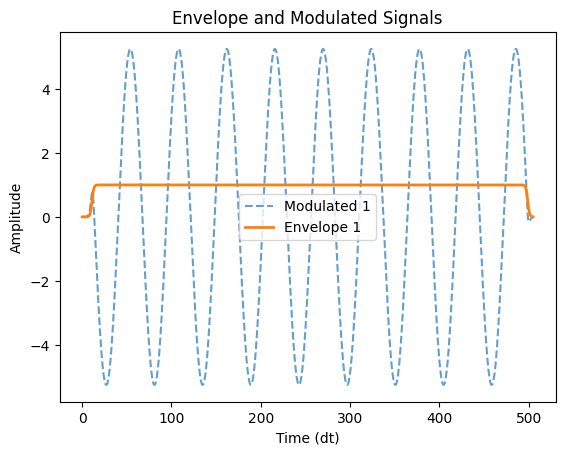

In [16]:
# pulse = Pulse(omega=max_fidelity_freq, amp=max_fidelity_amp)
pulse = Pulse(omega=max_fidelity_freq, amp=max_fidelity_amp)
Pulse.plot_pulse([(pulse, args)], t_list)

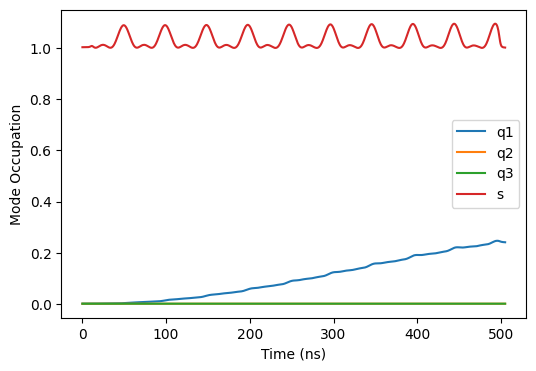

In [17]:
# Plot the state evolution (<n> vs time) for each mode (one plot total)
fig, ax = plt.subplots(figsize=(6, 4))
for k, mode in enumerate(qs.modes):
    # if k == 3:  # don't plot the SNAIL
    #     continue
    ax.plot(t_list, solve_result.expect[k], label=mode.name)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Mode Occupation")
ax.legend()
plt.show()